In [ ]:
# We aim to compute the convolution of gaussian with cactus distributions
# This is a side-mission of the write-up
# Last Update: 11/11/2021

Text(0.5, 0, 't')

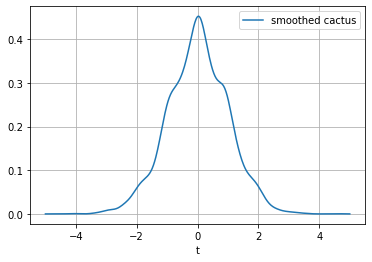

In [11]:
# Generate a kernel density estimator from samples

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
sen=1
var=1

filename = ('privacy_data/cactus_samples_d%1.1f_v%1.2f.npy' %(sen, var))
samples=np.load(filename)
kernel = gaussian_kde(samples)

x=np.linspace(-5,5,500)
plt.plot(x,kernel.pdf(x),label='smoothed cactus')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('t')

Text(0.5, 0, 'x')

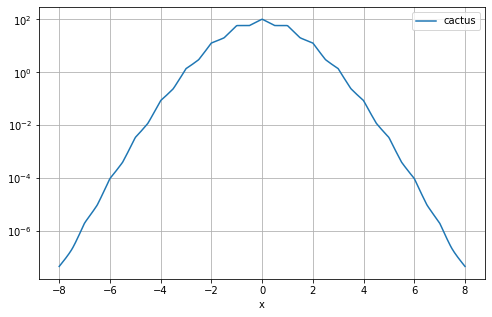

In [8]:
# Use the triditional way to compute the convolution of gaussian and cactus

import numpy as np
import scipy.stats as stats
from scipy import signal
import matplotlib.pyplot as plt

stddev = 1
sen = 1
r=0.9

def pdf_cactus(X,sen,stddev):
    
    filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,stddev**2))
    x = np.genfromtxt(filename, dtype=np.float32)
    x = x.reshape(-1)
    xmax=max(x)
    n = len(x)/2//xmax

    filename = ('/home/fwei16/privacy_data/cactus_pdf_d%.1f_v%.2f.csv' %(sen,stddev**2))
    p = np.genfromtxt(filename, dtype=np.float32)*n
    p = p.reshape(-1)    
    
    y=np.zeros(len(X))
    
    for j in range(len(X)):
        if np.abs(X[j])>=xmax:
            y[j]=n*p[j]*r**(n*(np.abs(X[j])-xmax))
        else:
            for i in range(len(x)-1):
                if x[i]<=X[j] and X[j]<x[i+1]:
                    y[j] = n*p[i]+n**2*(p[i+1]-p[i])*(X[j]-x[i])
                    break
    return y
xmax=8
x=np.linspace(-xmax,xmax,500)
plt.figure(figsize=(8,5))
plt.semilogy(x,pdf_cactus(x,sen,stddev),label='cactus')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('x')

normal_dist0 = stats.norm(loc=0, scale=stddev)
normal_dist1 = stats.norm(loc=sen, scale=stddev)

delta = 1e-4
big_grid = np.arange(-xmax,xmax,delta)

pmfc = pdf_cactus(big_grid,sen,stddev)*delta

pmfc = kernel.pdf(big_grid)*delta

pmf0 = normal_dist0.pdf(big_grid)*delta

pmf1 = normal_dist1.pdf(big_grid)*delta

conv_pmf0 = signal.convolve(pmfc,pmf0,'same')
conv_pmf1 = signal.convolve(pmfc,pmf1,'same')

# compute the c.f. of the convolutions

t = np.arange(-10,10,0.1)
a=0

cf=[0]*len(t)
for i in range(len(t)):
    cf[i] = sum(conv_pmf0*np.exp((a+t[i]*1j)*np.log(conv_pmf0/conv_pmf1)))
    
cf = [sum(conv_pmf0*np.exp((a+t[i]*1j)*np.log(conv_pmf0/conv_pmf1))) for i in range(len(t))]

plt.figure(figsize=(8,5))
plt.semilogy(t,np.abs(cf), label='c.f.')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title('c.f. of convolution pdf, stddev=%.2f, sen=%.1f' %(stddev, sen))
plt.grid(True)